In [2]:
import math
import random
import numpy as np
import pandas as pd

### Skew@k

In [3]:
def skewk(rankedlist, prob, attr, k): 
    count = 0
    epsilon = 0.000001
    for item in rankedlist[:k]:
        if item['real_attr']==attr:
            count+=1
    frac_ranked = count/k
    countall = 0
#     for item in rankedlist:
#         if item['attr']==attr:
#             countall+=1
    frac_real = prob[attr]
    return (frac_ranked+epsilon)/(frac_real+epsilon) #Removed math.log

### NDKL

In [4]:
def KL(p, q):
    """ Computes Kullback-Leibler divergence between two distributions.
    Both p and q must be dictionaries from events to probabilities.
    The divergence is defined only when q[event] == 0 implies p[event] == 0.
    """
    KL = 0
    epsilon = 1e-10
    for i in p:
        if p[i]>0:
            KL+= p[i] * math.log((p[i]+epsilon)/(q[i]+epsilon))
        else:
            KL+=0
    return KL

In [5]:
def NDKL(tau,q):
    Z = sum(1/math.log2(i+1) for i in range(1,len(tau)+1))
    DKL = 0
    #q = getdist(tau)
    for k in range(1,len(tau)+1):
        p = getdist(tau[:k])
        DKL+= (1/math.log2(k+1))*KL(p,q)
    return DKL/Z

### NDCG

In [6]:
def DCG(R, k, method=0):
    r = [i['score'] for i in R]
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def NDCG(r, k, method=0):
    dcg_max = DCG(sorted(r, key = lambda i: i['score'],reverse=True), k, method)
    if not dcg_max:
        return 0.
    return DCG(r, k, method) / dcg_max

In [7]:
def getdist(p):  
    # Given a list, return the protected attr dist as a dictionary 
    d = {}
    for person in p:
        if person['real_attr'] not in d:
            d[person['real_attr']]=1
        else:
            d[person['real_attr']]+=1
    for attr in d:
        d[attr] = d[attr]/len(p)
    return d

In [8]:
# Compute Attention Function for the different attributes
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
# #     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
# #     'text.usetex': True,
#     'pgf.rcfonts': False
# })

# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })


import seaborn as sns
sns.set_style('darkgrid')


def getskews(rankedlist,prob):
    skew_dic = {}
    #countdict = {}
    atts = set([])
    for item in rankedlist:
        atts.add(item['attr'])
    
    for attr in atts:
        skew_dic[attr] = skewk(rankedlist,prob,attr,len(rankedlist))

    return skew_dic
    
def get_score(rankedlist):
    score_dic = {}
    #countdict = {}
    for item in rankedlist:

        if item['attr']+'_list' not in score_dic:
            score_dic[item['attr']+'_list'] = []
        #if item['attr'] not in countdict:
            #countdict[item['attr']] = 0
        score_dic[item['attr']+'_list'].append(item['score'])
        #countdict[item['attr']] +=1
        
    score_dic2 = {}
        
    for attl in score_dic:
        attr = attl[:-5]
        score_dic2[attr] = np.median(score_dic[attl])

#     X= sorted(att_dic.keys())
#     g = sns.barplot(x=X,y=[att_dic[i] for i in X])
#     g.set_yscale("log", basey=10)
#     plt.xticks(rotation=75)
#     plt.show()
    
    return score_dic2


def get_attention(rankedlist, dist = 'log', p = -1):
    sns.set(font_scale=1.5)
    base_attention = 100
    i = 1
    att_dic = {}
    #countdict = {}
    for item in rankedlist:
        if dist == 'log':
            attention = base_attention/math.log2(i+1)
        elif dist == 'geometric':
            if p== -1:
                print('Error, set p = fraction of attention for the first result')
                return
            else:
                attention = base_attention*((1 - p)**i)*p
        else:
            print('Error, dist must be log or geometric')

        if item['attr']+'_list'  not in att_dic:
            att_dic[item['attr']+'_list'] = []
#         if item['attr'] not in countdict:
#             countdict[item['attr']] = 0
        att_dic[item['attr']+'_list'].append(attention)
#         countdict[item['attr']] +=1
        i+=1
    
    att_dic2 = {}                                      
   
    for attl in att_dic:
        attr = attl[:-5]
        if dist == 'geometric':
            att_dic2[attr] = np.mean(att_dic[attl])
        else:
            att_dic2[attr] = np.median(att_dic[attl])


#     X= sorted(att_dic2.keys())
#     g = sns.barplot(x=X,y=[att_dic2[i] for i in X])
#     if dist == 'geometric':
#         g.set_yscale("log", basey=10)
#     plt.xticks(rotation=75)
#     plt.show()
    
    return att_dic2

def get_di(rankedlist, dist = 'log', p = -1):
    base_attention = 100
    i = 1
    att_dic = {}
    #countdict = {}
    for item in rankedlist:
        if dist == 'log':
            attention = base_attention/math.log2(i+1)
        elif dist == 'geometric':
            if p== -1:
                print('Error, set p = fraction of attention for the first result')
                return
            else:
                attention = base_attention*((1 - p)**i)*p
        else:
            print('Error, dist must be log or geometric')

        if item['attr']+'_list' not in att_dic:
            att_dic[item['attr']+'_list'] = []
        #if item['attr'] not in countdict:
            #countdict[item['attr']] = 0
        att_dic[item['attr']+'_list'].append(attention*item['score'])
        #countdict[item['attr']] +=1
        i+=1
        
    att_dic2 = {}                                      
    for attl in att_dic:
        attr = attl[:-5]
        att_dic2[attr] = np.median(att_dic[attl])
    
    return att_dic2



def getheatmap(dict1, dict2, name1, name2):
    sns.set(font_scale=0.9)
    l = []
    for i in sorted(dict1):
        k = {}
        for j in sorted(dict2):
            if i == j:
                k[j] = dict1[i]-dict2[j]
            else:
                k[j] = (dict1[i]-dict1[j])-(dict1[i]-dict2[j])
        k['name']=i
        l.append(k)
    df = pd.DataFrame(l)
    df.set_index('name',inplace=True, drop=True)
    mask_ut=np.triu(np.ones(df.shape)).astype(np.bool)
    mask_ut[np.diag_indices_from(mask_ut)] = False
    ax = sns.heatmap(df,annot=True)
#     ax = sns.heatmap(df,mask=mask_ut,annot=True)
    ax.set(xlabel=name2, ylabel=name1)
    plt.show()
    return df

In [9]:
def showmetrics(rankedlist,prob):
    ndkl = NDKL(rankedlist,prob)
    attd = get_attention(rankedlist)
    skewd = getskews(rankedlist,prob)
    scoredic = get_score(rankedlist)
    geoattd = get_attention(rankedlist,dist='geometric',p=0.1)
    
    print('NDKL of this ranking: ',ndkl)
    print('Skew Measure: ',skewd)
    vals = skewd.values()
    print("\t Mean skew :", np.mean(list(vals)))
    print("\t Standard deviation of skew :", np.std(list(vals)))
    print("\t Skew bias ratio: ", min(vals)/max(vals))

    vals = attd.values()
#     print('Group fairness metrics\n\n')
    print('Groupwise Exposure: ', attd)
    print("\t Mean exposure :", np.mean(list(vals)))
    print("\t Standard deviation of exposure :", np.std(list(vals)))
    print("\t Exposure bias ratio: ", min(vals)/max(vals))

    
    DT = {}
    for k in attd:
        DT[k]=attd[k]/scoredic[k]
    
    vals = DT.values()
    print('Disparate Treatment Metric')
    print('Group exposure/utility: ',DT)
    print("\t Mean exposure/utility :", np.mean(list(vals)))
    print("\t Standard deviation of exposure/utility :", np.std(list(vals)))
    print('\t Disparate Treatment Min Bias Ratio: ',min(vals)/max(vals))
    
#     print('Individual fairness metric \n\n')
    print('Disparate Impact Metric')
    DI = get_di(rankedlist)
    print('Group exposure_i*utility_i: ',DI)
    vals = DI.values()
    print("\t Mean exposure_i*utility_i :", np.mean(list(vals)))
    print("\t Standard deviation of exposure_i*utility_i :", np.std(list(vals)))
    print('\t Disparate Impact Min Bias Ratio: ',min(vals)/max(vals))
    
    return ndkl,attd,DI,DT,skewd,geoattd


## Shuffle

In [10]:
#samplepred

In [11]:
# print(samplepred)

from numpy.random import choice


def misinterpret(oglist, ethaccdict):
    #attrs = set([i['real_attr'] for i in oglist])
    newlist = []
    oc = Counter([item['real_attr'].split('_')[0] for item in oglist])
    cd = {}
    
    for c in oc:
        if c != 'Other':
            list_of_candidates = list(oc.keys())
            raw_p = [float(ethaccdict[c][i]) for i in list_of_candidates]
            probability_distribution = [i/sum(raw_p) for i in raw_p]
            cd[c] = list(choice(list_of_candidates, oc[c], p=probability_distribution))
    for item in oglist:
        ograce = item['real_attr'].split('_')[0]
        if ograce != 'Other':
            oggen = item['real_attr'].split('_')[1]
            item['attr']=str(cd[ograce].pop()) +'_'+oggen
            newlist.append(item)
    return newlist

### Detgreedy, DetCons, DetRelaxed implementation

In [12]:
# attributes are set as a list attr_list
import operator
import math

def rev_dict(d, reverse_flag = True):
    return sorted(d.items(),key=operator.itemgetter(1),reverse=reverse_flag)


def det_algo(score_dict, algo_type, prob, kmax):
    scoreList = [(elem['attr'], elem['score'], elem['real_attr']) for elem in score_dict]
#     print(score_dict)
    
    rankedAttList   = []
    rankedScoreList = []
    rankedRealAttrList = []
    AttrList        = list(set([elem[0] for elem in scoreList]))
    AttrCounts      = {}
    GlobalAttrProb  = prob
    AttrScores      = {}
    GlobalAttrCounts = {}
    RealAttrLocs     = {}
    
    newrankedList = []
    
    KMAX = kmax

    for i, attr in enumerate(AttrList):
        AttrCounts[attr]=0
        #GlobalAttrProb[attr] = sum([1 for elem in scoreList if elem[0]==attr])/len(scoreList)
        GlobalAttrCounts[attr]= sum([1 for elem in scoreList if elem[0]==attr])
        AttrScores[attr] = [elem[1] for elem in scoreList if elem[0]==attr] # to be initialized 
        RealAttrLocs[attr]= [elem[2] for elem in scoreList if elem[0]==attr] # to be initialized 
        
    for k in range(0, KMAX):
        belowMin = {}
        belowMax = {}
        belowMaxNorm = {}
        belowMaxNormSet = {}
        belowMinFlag= False
    
        for attr in AttrList:
            if AttrCounts[attr] < math.floor(GlobalAttrProb[attr]*k):
                belowMin[attr] = AttrScores[attr][AttrCounts[attr]]
                belowMinFlag = True
            elif AttrCounts[attr] <= math.ceil(GlobalAttrProb[attr]*k) and AttrCounts[attr]< GlobalAttrCounts[attr]:
                try:
                    belowMax[attr]        = AttrScores[attr][AttrCounts[attr]]
                    belowMaxNorm[attr]    = math.ceil(GlobalAttrProb[attr]*k)/GlobalAttrProb[attr]
                    belowMaxNormSet[attr] = math.ceil(math.ceil(GlobalAttrProb[attr]*k)/GlobalAttrProb[attr])
                except Exception as e:
                    import pdb; pdb.set_trace()

#         print(k, belowMin, belowMax)
        nextAttr = None
    
        if belowMinFlag:
            nextAttr = rev_dict(belowMin)[0][0]
#             nextScore = rev_dict(belowMin)[0][1]
#             print(nextAttr, nextScore, AttrScores[nextAttr][AttrCounts[nextAttr]])
#             nextRealAttr = rev_dict()
        else:
            if algo_type=='DetGreedy':            
                sorted_dict = rev_dict(belowMax)
                nextAttr    = sorted_dict[0][0]
#                 nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
            elif algo_type =='DetCons':
                sorted_dict = rev_dict(belowMaxNorm, False)
                nextAttr    = sorted_dict[0][0]
#                 nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
            elif algo_type =='DetRelaxed':
                sorted_dict = rev_dict(belowMaxNormSet, False)
                min_attr_set = [elem[0] for elem in sorted_dict if elem[1]==sorted_dict[0][1]]
                prunebelowMax = {}
                for elem in belowMax:
                    if elem in min_attr_set:
                        prunebelowMax[elem]=belowMax[elem]
                sorted_dict2 = rev_dict(prunebelowMax)
                nextAttr    = sorted_dict2[0][0]
#                 nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
#                 nextRealAttr = RealAttrLocs[nextAttr][AttrCounts[nextAttr]]
    
        nextScore   = AttrScores[nextAttr][AttrCounts[nextAttr]]
        nextRealAttr = RealAttrLocs[nextAttr][AttrCounts[nextAttr]]
        rankedAttList.append(nextAttr)
        rankedScoreList.append(nextScore)
        rankedRealAttrList.append(nextRealAttr)
        
        newrankedList.append({'attr':nextAttr,'score':nextScore, 'real_attr': nextRealAttr})
        AttrCounts[nextAttr]+=1
        
    return newrankedList

In [13]:
a = {'a':(1,2), 'b':(5,3), 'c':(2,7)}
print(sorted(a.items(), key= lambda x: x[1][0], reverse= True))

[('b', (5, 3)), ('c', (2, 7)), ('a', (1, 2))]


# DetConsSorted Implementation

In [14]:
from collections import defaultdict as ddict
import operator


def swap(temp_list, pos_i, pos_j):
    temp = temp_list[pos_i]
    temp_list[pos_i] = temp_list[pos_j]
    temp_list[pos_j] = temp

def det_const_sort(score_dict, prob, kmax):
    
    scoreList             = [(elem['attr'], elem['score'], \
                        elem['real_attr']) for elem in score_dict]
    AttrList              = list(set([elem[0] for elem in scoreList]))
    AttrScores            = {}
    AttrCount             = {}
    minAttrCount          = {}
    GlobalAttrCounts      = {}
    rankedAttrList        = {} #[]
    rankedScoreList       = {} #[]
    maxIndices            = {} #[]
    lastEmpty             =  0
    k                     =  0
    
    for i, attr in enumerate(AttrList):
        AttrCount[attr]        = 0
        minAttrCount[attr]     = 0
        GlobalAttrCounts[attr] = sum([1 for elem in scoreList if elem[0]==attr])
        AttrScores[attr]       = [(elem[1],elem[2]) for elem in scoreList if elem[0]==attr] # to be initialized 
        
    while lastEmpty       <= kmax:        
        
        if lastEmpty == len(scoreList):
            break
        
        k+=1
        tempMinAttrCount  = ddict(int)
        changedMins       = {}
        for attr in AttrList:
            tempMinAttrCount[attr] = math.floor(k*prob[attr])
            if minAttrCount[attr] < tempMinAttrCount[attr] and minAttrCount[attr] < GlobalAttrCounts[attr]:
                changedMins[attr]  = AttrScores[attr][AttrCount[attr]]
                    
        if len(changedMins) !=0:
            ordChangedMins  = sorted(changedMins.items(), key= lambda x: x[1][0], reverse= True)
            for elem in ordChangedMins:
                rankedAttrList[lastEmpty] = elem[0]
                rankedScoreList[lastEmpty]= AttrScores[elem[0]][AttrCount[elem[0]]] # (score, real_attr)
                maxIndices[lastEmpty]     = k
                start                     = lastEmpty
                while start > 0 and maxIndices[start-1] >= start and rankedScoreList[start-1][0]< rankedScoreList[start][0]:                
                    swap(rankedScoreList, start-1, start)
                    swap(maxIndices, start-1, start)
                    swap(rankedAttrList, start-1, start)
                    start -= 1
                AttrCount[elem[0]]+=1
                lastEmpty+=1
            minAttrCount= dict(tempMinAttrCount)
        
    
    newRankList = []
    
    rankedAttrArr  = [rankedAttrList[i] for i in sorted(rankedAttrList)]
    rankedScoreArr = [rankedScoreList[i] for i in sorted(rankedScoreList)]
    for attr, score in zip(rankedAttrArr, rankedScoreArr ):
        newRankList.append({'attr':attr, 'score':score[0], 'real_attr': score[1]})
        
    return newRankList

In [15]:
# K = len(incomerank_og)
# incomedetconsort_og = det_const_sort(incomerank_og,incomedist,K)
# incomedetconsort_shuff_dict = det_const_sort(incomerank_shuffled_dict,incomedist,K)
# incomedetconsort_shuff_ethncolor = det_const_sort(incomerank_shuffled_ethncolor,incomedist,K)
# incomedetconsort_shuff_cnn = det_const_sort(incomerank_shuffled_cnn,incomedist,K)

### Simulation

In [16]:
#simulate_err({"White":0.33,"Black":0.33,"Asian":0.33})

In [17]:
def genprob(attrlist):
    prob = {}
    s = 0
    for attr in attrlist:
        p = np.random.uniform(0,1)
        s+=p
        prob[attr]=p
    for attr in attrlist:
        prob[attr]/=s
    return prob

In [18]:
def getcandidates(prob):
    elements = list(prob.keys())
    candidates = []
    for e in elements:
        for n in range(1000):#(int(k/len(elements))):
            candidates.append(e)
    clist = []
    idn = 1
    for c in candidates:
        cand = {}
        cand['id']= str(idn)
        idn+=1
        cand['attr']= c
        cand['real_attr']= c
        cand['score']=np.random.uniform(0,1)
        clist.append(cand)
    clist.sort(key = lambda i: i['score'],reverse=True)
    return clist

In [19]:
def getscores(prob,k):

    print("Vanilla NDKL: ", NDKL(score_dict[:k],prob))

    a = det_algo(score_dict,'DetGreedy',prob,k)
    print("DetGreedy NDKL: ", NDKL(a,prob))

    a = det_algo(score_dict,'DetCons',prob,k)
    print("DetCons NDKL: ", NDKL(a,prob))

    a = det_algo(score_dict,'DetRelaxed',prob,k)
    print("DetRelaxed NDKL: ", NDKL(a,prob))
    
    a = det_const_sort(score_dict, prob, k)
    print("DetConsSort NDKL: ", NDKL(a,prob))


In [20]:
def simulate():#(N):
    vanilla = []
    detgreedy = []
    detcons = []
    detrelaxed = []
    vanilla2 = []
    detgreedy2 = []
    detcons2 = []
    detrelaxed2 = []
    
    detconssort = []
    detconssort2=[]
    probs = [
        {"White":0.33,"Black":0.33,"Asian":0.33},
        {"White":0.2,"Black":0.3,"Asian":0.5},
        {"White":0.1,"Black":0.3,"Asian":0.6},
        {"White":0.1,"Black":0.2,"Asian":0.7}
    ]
    
    
    #for n in range(N):
    
    for prob in probs:
        #prob = genprob(['White','Black','Asian'])
        score_dict = getcandidates(prob)
        print(score_dict)
        
        k = 100
        
        vanilla.append(NDKL(score_dict[:k],prob))
        vanilla2.append(NDCG(score_dict[:k],k))


#         a = det_algo(score_dict,'DetGreedy',prob,k)
#         detgreedy.append(NDKL(a,prob))
#         detgreedy2.append(NDCG(a,k))

#         a = det_algo(score_dict,'DetCons',prob,k)
#         detcons.append(NDKL(a,prob))
#         detcons2.append(NDCG(a,k))


#         a = det_algo(score_dict,'DetRelaxed',prob,k)
#         detrelaxed.append(NDKL(a,prob))
#         detrelaxed2.append(NDCG(a,k))

        a = det_const_sort(score_dict,prob,k)
        detconssort.append(NDKL(a,prob))
#         detconssort2.append(NDCG(a,k))

        
    print("NDKL")
        
    print("Vanilla: ", np.mean(vanilla))
    print("DetGreedy: ", np.mean(detgreedy))
    print("DetCons: ", np.mean(detcons))
    print("DetRelaxed: ", np.mean(detrelaxed))
    print("DetConsSort: ", np.mean(detconssort))
    
#     print("NDCG")
        
#     print("Vanilla: ", np.mean(vanilla2))
#     print("DetGreedy: ", np.mean(detgreedy2))
#     print("DetCons: ", np.mean(detcons2))
#     print("DetRelaxed: ", np.mean(detrelaxed2))
#     print("DetConsSort: ", np.mean(detconssort2))

In [21]:
def randomize(oglist, acc):
    attrs = set([i['real_attr'] for i in oglist])
    newlist = []
    for item in oglist:
        if random.random() < acc: #True
            item['attr']=item['real_attr']
        else:
            item['attr']=random.choice(list(attrs - set(item['real_attr'])))
        newlist.append(item)
    return newlist

In [28]:
def simulate_err(prob):#(N):
    
#     probs = [
#         {"White":0.33,"Black":0.33,"Asian":0.33},
#         {"White":0.2,"Black":0.3,"Asian":0.5},
#         {"White":0.1,"Black":0.3,"Asian":0.6},
#         {"White":0.1,"Black":0.2,"Asian":0.7}
#     ]
    
    probs = [prob]
    
    dlist = []
    
    
    #for n in range(N):
    
    for prob in probs:
        print('Distribution: ', prob,'\n')
        #prob = genprob(['White','Black','Asian'])
        score_dict = getcandidates(prob)
        
        k = 100
        
        print('Simulating original protected categories')
        
        vanilla_NDKL = []
        algo_NDKL = []
        vanilla_attention = []
        algo_attention = []
        vanilla_DT = []
        algo_DT = []
        vanilla_DI = []
        algo_DI = []
#         detgreedy = []
#         detcons = []
#         detrelaxed = []
#         vanilla2 = []
#         detgreedy2 = []
#         detcons2 = []
#         detrelaxed2 = []
        #detconssort = []
#         detconssort2 =[]
        
        
#         for i in range(100):
#             vanilla_NDKL.append(NDKL(score_dict[:k],prob))
#             a = det_const_sort(score_dict,prob,k)
#             algo_NDKL.append(NDKL(a,prob))
#             vattd = get_attention(score_dict[:k])
#             vanilla_attention.append(min(vattd.values())/max(vattd.values()))
#             vscore = get_score(score_dict[:k])
#             DT = {}
#             for ky in vattd:
#                 DT[ky]=vattd[ky]/vscore[ky]
#             vanilla_DT.append(min(DT.values())/max(DT.values()))
#             DI = get_di(score_dict[:k])
#             vanilla_DI.append(min(DI.values())/max(DI.values()))

#             aattd = get_attention(a)
#             algo_attention.append(min(aattd.values())/max(aattd.values()))
#             ascore = get_score(a)
#             DT = {}
#             for ky in aattd:
#                 DT[ky]=aattd[ky]/ascore[ky]
#             algo_DT.append(min(DT.values())/max(DT.values()))
#             DI = get_di(a)
#             algo_DI.append(min(DI.values())/max(DI.values()))
        
        
#             vanilla.append(NDKL(score_dict[:k],prob))
# #             vanilla2.append(NDCG(score_dict[:k],k))


# #             a = det_algo(score_dict,'DetGreedy',prob,k)
# #             detgreedy.append(NDKL(a,prob))
# #             detgreedy2.append(NDCG(a,k))

# #             a = det_algo(score_dict,'DetCons',prob,k)
# #             detcons.append(NDKL(a,prob))
# #             detcons2.append(NDCG(a,k))


# #             a = det_algo(score_dict,'DetRelaxed',prob,k)
# #             detrelaxed.append(NDKL(a,prob))
# #             detrelaxed2.append(NDCG(a,k))

#             a = det_const_sort(score_dict,prob,k)
#             detconssort.append(NDKL(a,prob))
#             detconssort2.append(NDCG(a,k))

        
#         print("NDKL\n")

#         print("Vanilla: ", np.mean(vanilla))
#         print("DetGreedy: ", np.mean(detgreedy))
#         print("DetCons: ", np.mean(detcons))
#         print("DetRelaxed: ", np.mean(detrelaxed),'\n\n')
        
        #dlist.append(["Ground truth",np.mean(vanilla),np.mean(detgreedy),np.mean(detcons),np.mean(detrelaxed), np.mean(detconssort)])



#         print("NDCG\n")

#         print("Vanilla: ", np.mean(vanilla2))
#         print("DetGreedy: ", np.mean(detgreedy2))
#         print("DetCons: ", np.mean(detcons2))
#         print("DetRelaxed: ", np.mean(detrelaxed2),'\n\n\n')
        
        for acc in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
            
            print('Simulating accuracy: ', acc)
            
            
            vanilla_NDKL = []
            algo_NDKL = []
            vanilla_attention = []
            algo_attention = []
            vanilla_DT = []
            algo_DT = []
            vanilla_DI = []
            algo_DI = []

#             detgreedy = []
#             detcons = []
#             detrelaxed = []
#             vanilla2 = []
#             detgreedy2 = []
#             detcons2 = []
#             detrelaxed2 = []
            
#             detconssort2 =[]
        
            
            for i in range(100):
            
                score_dict_rand = randomize(score_dict,acc)

                vanilla_NDKL.append(NDKL(score_dict_rand[:k],prob))
                a = det_const_sort(score_dict_rand,prob,k)
                algo_NDKL.append(NDKL(a,prob))
                vattd = get_attention(score_dict_rand[:k])
                vanilla_attention.append(min(vattd.values())/max(vattd.values()))
                vscore = get_score(score_dict_rand[:k])
                DT = {}
                for ky in vattd:
                    DT[ky]=vattd[ky]/vscore[ky]
                vanilla_DT.append(min(DT.values())/max(DT.values()))
                DI = get_di(score_dict_rand[:k])
                vanilla_DI.append(min(DI.values())/max(DI.values()))
                
                aattd = get_attention(a)
                algo_attention.append(min(aattd.values())/max(aattd.values()))
                ascore = get_score(a)
                DT = {}
                for ky in aattd:
                    DT[ky]=aattd[ky]/ascore[ky]
                algo_DT.append(min(DT.values())/max(DT.values()))
                DI = get_di(a)
                algo_DI.append(min(DI.values())/max(DI.values()))

                

                
                
#                 vanilla2.append(NDCG(score_dict_rand[:k],k))


#                 a = det_algo(score_dict_rand,'DetGreedy',prob,k)
#                 detgreedy.append(NDKL(a,prob))
#                 detgreedy2.append(NDCG(a,k))

#                 a = det_algo(score_dict_rand,'DetCons',prob,k)
#                 detcons.append(NDKL(a,prob))
#                 detcons2.append(NDCG(a,k))


#                 a = det_algo(score_dict_rand,'DetRelaxed',prob,k)
#                 detrelaxed.append(NDKL(a,prob))
#                 detrelaxed2.append(NDCG(a,k))
                
                
#                 detconssort2.append(NDCG(a,k))



#             print("NDKL\n")

#             print("Vanilla: ", np.mean(vanilla))
#             print("DetGreedy: ", np.mean(detgreedy))
#             print("DetCons: ", np.mean(detcons))
#             print("DetRelaxed: ", np.mean(detrelaxed),'\n\n')
            
            #dlist.append([str(acc),np.mean(vanilla),np.mean(detgreedy),np.mean(detcons),np.mean(detrelaxed), np.mean(detconssort)])
            dlist.append([acc,np.mean(vanilla_NDKL), np.mean(algo_NDKL), np.mean(vanilla_attention)
                         , np.mean(algo_attention),np.mean(vanilla_DT), np.mean(algo_DT), np.mean(vanilla_DI)
                         , np.mean(algo_DI)])



#             print("NDCG\n")

#             print("Vanilla: ", np.mean(vanilla2))
#             print("DetGreedy: ", np.mean(detgreedy2))
#             print("DetCons: ", np.mean(detcons2))
#             print("DetRelaxed: ", np.mean(detrelaxed2),'\n\n\n')

#     df = pd.DataFrame(dlist, columns = ['Accuracy', 'Vanilla', 'DetGreedy', 'DetCons', 'DetRelaxed','DetConsSort']) 
#     dlist.append([1.0,np.mean(vanilla_NDKL), np.mean(algo_NDKL), np.mean(vanilla_attention)
#                          , np.mean(algo_attention),np.mean(vanilla_DT), np.mean(algo_DT), np.mean(vanilla_DI)
#                          , np.mean(algo_DI)])
    
    
    df = pd.DataFrame(dlist, columns = ['Accuracy','Vanilla NDKL','Algo NDKL', 'Vanilla_attention_biasratio',
                                       'Algo_attention_biasratio', 'Vanilla_DT_biasratio', 'Algo_DT_biasratio',
                                        'Vanilla_DI_biasratio', 'Algo_DI_biasratio']) 

    print('\n\nMean over 100 simulations')

    return df

# Accuracy vs Fairness (NDKL) - synthetic data

In [29]:
#print(simulate_err({"White":0.33,"Black":0.33,"Asian":0.33}).to_latex())
dfA = simulate_err({"White":0.33,"Black":0.33,"Asian":0.33})
row1 = dfA.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.33, 'Black': 0.33, 'Asian': 0.33} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


Mean over 100 simulations
Vanilla NDKL 0.12636948123311176
Vanilla_attention_biasratio 0.9293107803373998
Vanilla_DT_biasratio 0.9332870113524636
Vanilla_DI_biasratio 0.9253504199341203


In [30]:
cols = ['Accuracy',
 'Algo NDKL',
 'Algo_attention_biasratio',
 'Algo_DT_biasratio',
 'Algo_DI_biasratio']

dfA[cols]
display(dfA)

,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.126369,0.123671,0.929311,0.975680,0.933287,0.981420,0.925350,0.969899
1,0.2,0.126369,0.123124,0.927947,0.975824,0.932010,0.982082,0.923898,0.969556
2,0.3,0.126369,0.121688,0.931428,0.975551,0.935282,0.981064,0.927592,0.969995
3,0.4,0.126369,0.120707,0.929236,0.974951,0.933024,0.980913,0.925463,0.968916
4,0.5,0.126369,0.115680,0.928022,0.975357,0.931966,0.980700,0.924095,0.969975
5,0.6,0.126369,0.115550,0.925572,0.975148,0.929472,0.980393,0.921694,0.969920
6,0.7,0.126369,0.113008,0.918980,0.975923,0.922987,0.980792,0.914985,0.971018
7,0.8,0.126369,0.110762,0.921048,0.976020,0.924928,0.980426,0.917185,0.971590
8,0.9,0.126369,0.107569,0.923167,0.975554,0.926729,0.979250,0.919603,0.971847
9,1.0,0.126369,0.104554,0.916317,0.974999,0.920040,0.977192,0.912609,0.972792


In [25]:
#print(simulate_err({"White":0.2,"Black":0.3,"Asian":0.5}).to_latex())
dfB = simulate_err({"White":0.2,"Black":0.3,"Asian":0.5})
row1 = dfB.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

display(dfB)

Distribution:  {'White': 0.2, 'Black': 0.3, 'Asian': 0.5} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9


Mean over 100 simulations
Vanilla NDKL 0.2045527553477856
Vanilla_attention_biasratio 0.931757821127917
Vanilla_DT_biasratio 0.9344913886872582
Vanilla_DI_biasratio 0.9290333791781386


,Accuracy,Vanilla NDKL,Algo NDKL,Vanilla_attention_biasratio,Algo_attention_biasratio,Vanilla_DT_biasratio,Algo_DT_biasratio,Vanilla_DI_biasratio,Algo_DI_biasratio
0,0.1,0.204553,0.189879,0.931758,0.978755,0.934491,0.987525,0.929033,0.967385
1,0.2,0.204553,0.176427,0.933453,0.978807,0.936069,0.988268,0.930845,0.966370
2,0.3,0.204553,0.165390,0.928615,0.979190,0.931458,0.988465,0.925780,0.965983
3,0.4,0.204553,0.154229,0.929993,0.979284,0.932819,0.987956,0.927176,0.966448
4,0.5,0.204553,0.136301,0.943396,0.979269,0.945695,0.988842,0.941102,0.965366
5,0.6,0.204553,0.129070,0.944261,0.979581,0.946505,0.988981,0.942023,0.965880
6,0.7,0.204553,0.112626,0.940166,0.979849,0.942586,0.988970,0.937751,0.965276
7,0.8,0.204553,0.105450,0.950326,0.980001,0.952302,0.989702,0.948355,0.964932
8,0.9,0.204553,0.095604,0.954752,0.980026,0.956565,0.989839,0.952943,0.964156
9,1.0,0.204553,0.095604,0.954752,0.980026,0.956565,0.989839,0.952943,0.964156


In [264]:
# print(simulate_err({"White":0.1,"Black":0.3,"Asian":0.6}).to_latex())
dfC = simulate_err({"White":0.1,"Black":0.3,"Asian":0.6})
row1 = dfC.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.1, 'Black': 0.3, 'Asian': 0.6} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9


Mean over 100 simulations
Vanilla NDKL 0.48581187650054325
Vanilla_attention_biasratio 0.9306928772257756
Vanilla_DT_biasratio 0.935824322628402
Vanilla_DI_biasratio 0.9255938308388915


In [265]:
dfD = simulate_err({"White":0.1,"Black":0.2,"Asian":0.7})
# print(simulate_err({"White":0.1,"Black":0.2,"Asian":0.7}).to_latex())
row1 = dfD.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.1, 'Black': 0.2, 'Asian': 0.7} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9


Mean over 100 simulations
Vanilla NDKL 0.4953329144514001
Vanilla_attention_biasratio 0.9316931443143406
Vanilla_DT_biasratio 0.9357742624472236
Vanilla_DI_biasratio 0.9276310058555878


In [267]:
dfE = simulate_err({"White":0.1,"Black":0.2,"Asian":0.6, "Latino":0.1})
row1 = dfE.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.1, 'Black': 0.2, 'Asian': 0.6, 'Latino': 0.1} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9


Mean over 100 simulations
Vanilla NDKL 0.26688499276221667
Vanilla_attention_biasratio 0.9042291894532037
Vanilla_DT_biasratio 0.9093225136526749
Vanilla_DI_biasratio 0.8991689932349313


In [271]:
dfA[cols]

,Accuracy,Algo NDKL,Algo_attention_biasratio,Algo_DT_biasratio,Algo_DI_biasratio
0,0.1,0.100864,0.976448,0.983678,0.968812
1,0.2,0.100838,0.975961,0.983203,0.968359
2,0.3,0.100037,0.975118,0.981794,0.968123
3,0.4,0.099354,0.975745,0.982868,0.968308
4,0.5,0.098442,0.975769,0.983728,0.967515
5,0.6,0.097059,0.975140,0.982910,0.966766
6,0.7,0.095637,0.975133,0.983273,0.966371
7,0.8,0.093537,0.975417,0.983469,0.966735
8,0.9,0.091787,0.974233,0.983130,0.964768
9,1.0,0.091787,0.974233,0.983130,0.964768


In [296]:
color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']

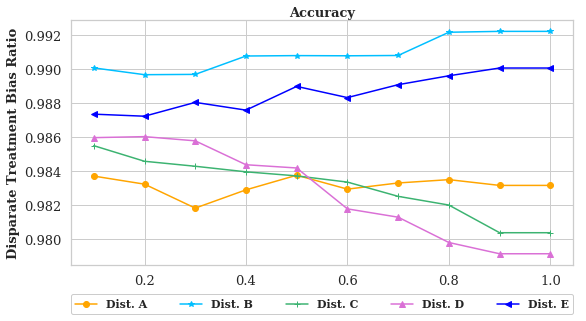

In [372]:
toplot = 'Algo_DT_biasratio'
from matplotlib.ticker import ScalarFormatter



plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (9,4.5)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')

ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

dfB[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[3],marker='*')
dfC[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[5],marker='+')
dfD[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[7],marker='^')
dfE[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[2],marker='<')

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)


plt.ylabel('Disparate Treatment Bias Ratio',fontsize=13,weight='bold')
plt.xlabel('Accuracy', fontsize =13,weight='bold')

plt.legend(['Dist. A', 'Dist. B', 'Dist. C', 'Dist. D', 'Dist. E'],
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.2,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=5,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('compare_dt_ratio.svg')

# Scratchpad - ignore this section

In [27]:
# from gender_classifier import *
# from ethnicity_classifier import *

# gender_dict1 = {}
# gender_dict1['seed']       = 100
# gender_dict1['classifier'] = 'gender'
# gender_dict1['middle_name']= 'no'

# ethnicity_dict1 = {}
# ethnicity_dict1['seed']       = 100
# ethnicity_dict1['classifier'] = 'ethnicity'
# ethnicity_dict1['middle_name']= 'no'

# gender_dict2 = {}
# gender_dict2['seed']       = 11747
# gender_dict2['classifier'] = 'gender'
# gender_dict2['middle_name']= 'no'

# ethnicity_dict2 = {}
# ethnicity_dict2['seed']       = 11747
# ethnicity_dict2['classifier'] = 'ethnicity'
# ethnicity_dict2['middle_name']= 'no'

# gender_dict3 = {}
# gender_dict3['seed']       = 42
# gender_dict3['classifier'] = 'gender'
# gender_dict3['middle_name']= 'no'

# ethnicity_dict3 = {}
# ethnicity_dict3['seed']       = 42
# ethnicity_dict3['classifier'] = 'ethnicity'
# ethnicity_dict3['middle_name']= 'no'

In [28]:
# from collections import defaultdict as ddict

# ethnic_map_dict = {}
# ethnic_map_dict['Latino']     =    'Hispanic'
# ethnic_map_dict['White']      =    'Caucasian'
# ethnic_map_dict['Asian']      =    'Asian'
# ethnic_map_dict['Black']      =    'African-American'
# ethnic_map_dict['NativeAm']   =    'Native American'

# gender_map_dict = {}
# gender_map_dict['M'] = 'Male'
# gender_map_dict['F'] = 'Female'


# def maj_vote(name):
#     eth_vals = ddict(int)
#     for edict in [ethnicity_dict1, ethnicity_dict2, ethnicity_dict3]:
#         v = call_ethnicity_inference(name, edict)
#         eth_vals[v]+=1
#     race  = max(eth_vals, key=eth_vals.get)
    
#     gen_vals = ddict(int)
#     for gdict in [gender_dict1, gender_dict2, gender_dict3]:
#         v = call_gender_inference(name, gdict)
#         gen_vals[v]+=1
    
#     gender = max(gen_vals, key=gen_vals.get)
    
#     return ethnic_map_dict[race]+'_'+gender_map_dict[gender]

In [29]:
# compasbaseline = pd.read_csv('compas_baseline_score.csv')

In [30]:
# compasbaseline['race+gender'] = compasbaseline['race'].astype(str)+'_'+compasbaseline['sex'].astype(str)

In [31]:
# display(compasbaseline.head())

In [32]:
# compasbaselinerank = []
# for i, row in compasbaseline.iterrows():
#     if row['race']=='Other':
#         continue
#     print(i, end='\r')
#     compasbaselinerank.append({'attr': maj_vote(row['name']),'real_attr':row['race+gender'],'score':row['two_year_recid_pred']})

In [33]:
# compasbaseline_original_rank = []
# for i, row in compasbaseline.iterrows():
#     if row['race']=='Other':
#         continue
#     print(i, end='\r')
#     compasbaseline_original_rank.append({'attr': row['race+gender'],'real_attr':row['race+gender'],'score':row['two_year_recid_pred']})

In [34]:
# ypred = []
# ytrue = []

# racepred =[]
# racetrue =[]
# genderpred = []
# gendertrue = []

# from sklearn.metrics import classification_report, accuracy_score, f1_score

# for elem in compasbaselinerank:
#     ypred.append(elem['attr'])
#     ytrue.append(elem['real_attr'])
    
#     preds = elem['attr'].split('_')
#     racepred.append(preds[0])
#     genderpred.append(preds[1])
    
#     trues = elem['real_attr'].split('_')
#     racetrue.append(trues[0])
#     gendertrue.append(trues[1])
    
# print(classification_report(ytrue, ypred))
# print(classification_report(racetrue, racepred))
# print(classification_report(gendertrue, genderpred))

In [35]:
# compasbaselinerank.sort(key=lambda x:x['score'],reverse=True)
# compasbaseline_original_rank.sort(key=lambda x:x['score'],reverse=True)

In [36]:
# print(len(compasbaselinerank),len(compasbaseline_original_rank))

In [37]:
# compasdist = getdist(compasbaselinerank)
# compasdistorg = getdist(compasbaseline_original_rank)

# print(compasdist)
# print(compasdistorg)

In [38]:
# print(NDKL(compasbaselinerank[:100],compasdist))
# print(NDKL(compasbaseline_original_rank[:100],compasdistorg))

# print(get_attention(compasbaselinerank[:100]))
# print(get_attention(compasbaseline_original_rank[:100]))


In [39]:
# print(NDKL(det_algo(compasbaselinerank,'DetGreedy',compasdist,100),compasdist))
# print(NDKL(det_algo(compasbaseline_original_rank,'DetGreedy',compasdistorg,100),compasdistorg))

# print(get_attention(det_algo(compasbaselinerank,'DetGreedy',compasdist,100)))
# print(get_attention(det_algo(compasbaseline_original_rank,'DetGreedy',compasdistorg,100)))

In [40]:
# print(NDKL(det_algo(compasbaselinerank,'DetCons',compasdist,100),compasdist))
# print(NDKL(det_algo(compasbaseline_original_rank,'DetCons',compasdistorg,100),compasdistorg))

# print(get_attention(det_algo(compasbaselinerank,'DetCons',compasdist,100)))
# print(get_attention(det_algo(compasbaseline_original_rank,'DetCons',compasdistorg,100)))

In [41]:
# print(NDKL(det_algo(compasbaselinerank,'DetRelaxed',compasdist,100),compasdist))
# print(NDKL(det_algo(compasbaseline_original_rank,'DetRelaxed',compasdistorg,100),compasdistorg))

# print(get_attention(det_algo(compasbaselinerank,'DetRelaxed',compasdist,100)))
# print(get_attention(det_algo(compasbaseline_original_rank,'DetRelaxed',compasdistorg,100)))

In [42]:
# skewtable = []
# for k in range(1,501):
#     sd = {}
#     sd['k']=k
#     mina = 1000
#     maxa = -1000
#     for attr in compasdist:
#         try:
#             s = skewk(compasbaselinerank,compasdist,attr,k)
#             if s < mina:
#                 mina = s
#                 sd['min_skew']=attr
#             if s > maxa:
#                 maxa = s
#                 sd['max_skew']=attr
#         except:
#             pass
#     skewtable.append(sd)

In [43]:
#skewtable

In [44]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [45]:
# pd.DataFrame(skewtable).set_index('k')

In [46]:
# compasdetrelaxed = det_algo(compasbaselinerank,'DetRelaxed',compasdist,500)

In [47]:
# skewtable = []
# for k in range(1,501):
#     sd = {}
#     sd['k']=k
#     mina = 1000
#     maxa = -1000
#     for attr in compasdist:
#         try:
#             s = skewk(compasdetrelaxed,compasdist,attr,k)
#             if s < mina:
#                 mina = s
#                 sd['min_skew']=attr
#             if s > maxa:
#                 maxa = s
#                 sd['max_skew']=attr
#         except:
#             pass
#     skewtable.append(sd)

In [48]:
# pd.DataFrame(skewtable).set_index('k')

In [49]:
# dictpred = json.load(open('../ethcounts_rate.json')) 
# ethncolorpred = json.load(open('../ethncolor_rate.json')) 

# print(dictpred)
# print(ethncolorpred)

map_keys = {
    'white':'White',
    'api':  'Asian',
    'asian':'Asian',
    'black':'Black',
    'hispanic':'Latino',
    'latino':'Latino'
}   

def norm_dict(ethncolorpred):
    org_dict = {}
    for race1 in ethncolorpred:
        org_dict[map_keys[race1]]={}
        for race2 in ethncolorpred[race1]:
            org_dict[map_keys[race1]][map_keys[race2]]= ethncolorpred[race1][race2]
    return org_dict

In [50]:
cats = ['White_Male', 'White_Female', 'Black_Male', 'Black_Female', 'Latino_Male', 'Latino_Female', 'Asian_Male', 'Asian_Female']
color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
d2c = dict(zip(cats, color_list))

In [51]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})

# Case Studies

In [239]:
import json
dictpred = json.load(open('../ethcounts_rate.json')) 
# ethncolorpred = norm_dict(json.load(open('../ethncolor_rate.json')))
cnnpred = json.load(open('../eth_CNN_probs.json')) 
ethncolorpred = norm_dict(json.load(open('../ethncolor_major_probs.json')))
bisgpred = json.load(open('../surgeo_probs.json'))
nameprismpred = json.load(open('../nameprism_ethprobs.json'))
deepfacepred = norm_dict(json.load(open('../ethface_probs.json')))

In [245]:
import pprint
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(deepfacepred)

{'Asian': {'Asian': 0.614580914789877,
           'Black': 0.15532853494311585,
           'Latino': 0.06779661016949153,
           'White': 0.16229394009751566},
 'Black': {'Asian': 0.10782380013149244,
           'Black': 0.7238658777120316,
           'Latino': 0.02827087442472058,
           'White': 0.14003944773175542},
 'Latino': {'Asian': 0.22010869565217392,
            'Black': 0.14605978260869565,
            'Latino': 0.32065217391304346,
            'White': 0.313179347826087},
 'White': {'Asian': 0.1185378590078329,
           'Black': 0.07780678851174935,
           'Latino': 0.10861618798955613,
           'White': 0.6950391644908617}}


# UCI Adult Income Data

In [53]:
incomerank_ogo = json.load(open('incomedatalist.json'))
from collections import Counter

In [54]:
# set([i['real_attr'] for i in incomerank_og])

In [55]:
incomerank_og = []
for item in incomerank_ogo:
    if item['real_attr'].split('_')[0] not in ['Other', 'NativeAm']:
        item['attr'] = item['real_attr']
        incomerank_og.append(item)

In [373]:
n_sim = 100
L = len(incomerank_og)
K = 300
incomedist = getdist(incomerank_og)

NDKL_dic = {}

attd_d = {}
geoattd_d = {}
DI_d = {}
DT_d = {}
skew_d = {}

for s in range(n_sim):
    print(s)
    incomerank_shuffled_ethncolor = misinterpret(copy.deepcopy(incomerank_og), ethncolorpred)
    incomerank_shuffled_cnn = misinterpret(copy.deepcopy(incomerank_og), cnnpred)
    incomerank_shuffled_bisg = misinterpret(copy.deepcopy(incomerank_og), bisgpred)
    incomerank_shuffled_nameprism = misinterpret(copy.deepcopy(incomerank_og), nameprismpred)
    incomerank_shuffled_deepface = misinterpret(copy.deepcopy(incomerank_og), deepfacepred)
    
    incomedetconsort_og = det_const_sort(incomerank_og,incomedist,K)
    #incomedetconsort_shuff_dict = det_const_sort(incomerank_shuffled_dict,incomedist,K)
    incomedetconsort_shuff_ethncolor = det_const_sort(incomerank_shuffled_ethncolor,incomedist,K)
    incomedetconsort_shuff_cnn = det_const_sort(incomerank_shuffled_cnn,incomedist,K)
    incomedetconsort_shuff_bisg = det_const_sort(incomerank_shuffled_bisg,incomedist,K)
    incomedetconsort_shuff_nameprism = det_const_sort(incomerank_shuffled_nameprism,incomedist,K)
    incomedetconsort_shuff_deepface = det_const_sort(incomerank_shuffled_deepface,incomedist,K)
    
    method_names = ['Baseline','Oracle','EthCnn','Ethncolor','BISG','Nameprism','Deepface']

    rankedlists = [incomerank_og, incomedetconsort_og,incomedetconsort_shuff_cnn, incomedetconsort_shuff_ethncolor,incomedetconsort_shuff_bisg, incomedetconsort_shuff_nameprism, incomedetconsort_shuff_deepface]

    for method_name, rankedlist in zip(method_names, rankedlists):
        if method_name not in NDKL_dic:
            NDKL_dic[method_name] = []
        NDKL_dic[method_name].append(NDKL(rankedlist[:K], incomedist))
        
#     maind = None

    dist = incomedist

    for method_name, rankedlist in zip(method_names, rankedlists):
#         attd = None
#         if method_name == 'PerfectInference':
#             ndkl,maind,DI,DT,skewd,geoattd = showmetrics(incomedetconsort_og[:K],dist)
#             attd = maind
#         else:
        print(method_name)
        ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
        if method_name not in attd_d:
            attd_d[method_name] = {}
        if method_name not in geoattd_d:
            geoattd_d[method_name] = {}
        if method_name not in DI_d:
            DI_d[method_name] = {}
        if method_name not in DT_d:
            DT_d[method_name] = {}
        if method_name not in skew_d:
            skew_d[method_name] = {}
        
        for cat in attd:
            if cat not in attd_d[method_name]:
                attd_d[method_name][cat] = []
            attd_d[method_name][cat].append(attd[cat])
            
        for cat in geoattd:
            if cat not in geoattd_d[method_name]:
                geoattd_d[method_name][cat] = []
            geoattd_d[method_name][cat].append(geoattd[cat])
            
        for cat in DI:
            if cat not in DI_d[method_name]:
                DI_d[method_name][cat] = []
            DI_d[method_name][cat].append(DI[cat])
            
        for cat in DT:
            if cat not in DT_d[method_name]:
                DT_d[method_name][cat] = []
            DT_d[method_name][cat].append(DT[cat])
            
        for cat in skewd:
            if cat not in skew_d[method_name]:
                skew_d[method_name][cat] = []
            skew_d[method_name][cat].append(skewd[cat])

0
Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Blac

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

Baseline
NDKL of this ranking:  0.20913852472661276
Skew Measure:  {'Black_Female': 0.15312503925569784, 'Asian_Male': 2.0830421894578097, 'Black_Male': 0.34048308598778765, 'White_Female': 0.4992423813177672, 'Asian_Female': 0.7145233492729295, 'White_Male': 1.3019553076332597}
	 Mean skew : 0.8487285588208753
	 Standard deviation of skew : 0.6597062437476127
	 Skew bias ratio:  0.07351029183693798
Groupwise Exposure:  {'White_Male': 13.96673142523192, 'White_Female': 13.80612310524288, 'Asian_Male': 13.610319799802884, 'Black_Female': 13.37184907421492, 'Asian_Female': 13.701659514328997, 'Black_Male': 12.38932866290727}
	 Mean exposure : 13.474335263621478
	 Standard deviation of exposure : 0.5180810752943937
	 Exposure bias ratio:  0.8870599917547668
Disparate Treatment Metric
Group exposure/utility:  {'White_Male': 16.171292017621823, 'White_Female': 16.025685923819324, 'Asian_Male': 15.857933133284067, 'Black_Female': 15.662074126391168, 'Asian_Female': 15.93183948568856, 'Black_

In [374]:
attdloop_inc = []
geoattdloop_inc = []
ndklloop_inc = []
DIloop_inc = []
DTloop_inc = []
skewloop_inc = []


for method_name in method_names:
    attd = {}
    for cat in attd_d[method_name]:
        attd[cat]= np.median(attd_d[method_name][cat])
    attdloop_inc.append(attd)
    
    geoattd = {}
    for cat in geoattd_d[method_name]:
        geoattd[cat]= np.mean(geoattd_d[method_name][cat])
    geoattdloop_inc.append(geoattd)
    
    DI = {}
    for cat in DI_d[method_name]:
        DI[cat]= np.median(DI_d[method_name][cat])
    DIloop_inc.append(DI)
    
    DT = {}
    for cat in DT_d[method_name]:
        DT[cat]= np.median(DT_d[method_name][cat])
    DTloop_inc.append(DT)
    
    skewd = {}
    for cat in skew_d[method_name]:
        skewd[cat]= np.median(skew_d[method_name][cat])
    skewloop_inc.append(skewd)

In [84]:
# #This is a simple last name frequency based classifier, not very accurate. Will also add charts for nameprism 
# #when we get access to it
# import copy 

# #incomerank_shuffled_dict = misinterpret(copy.deepcopy(incomerank_og), dictpred)
# incomerank_shuffled_ethncolor = misinterpret(copy.deepcopy(incomerank_og), ethncolorpred)
# incomerank_shuffled_cnn = misinterpret(copy.deepcopy(incomerank_og), cnnpred)
# incomerank_shuffled_bisg = misinterpret(copy.deepcopy(incomerank_og), bisgpred)
# incomerank_shuffled_nameprism = misinterpret(copy.deepcopy(incomerank_og), nameprismpred)
# incomerank_shuffled_deepface = misinterpret(copy.deepcopy(incomerank_og), deepfacepred)

In [85]:
# L = len(incomerank_og)
# K = 300

In [86]:
# incomedist = getdist(incomerank_og)

In [87]:
# incomedetconsort_og = det_const_sort(incomerank_og,incomedist,K)
# #incomedetconsort_shuff_dict = det_const_sort(incomerank_shuffled_dict,incomedist,K)
# incomedetconsort_shuff_ethncolor = det_const_sort(incomerank_shuffled_ethncolor,incomedist,K)
# incomedetconsort_shuff_cnn = det_const_sort(incomerank_shuffled_cnn,incomedist,K)
# incomedetconsort_shuff_bisg = det_const_sort(incomerank_shuffled_bisg,incomedist,K)
# incomedetconsort_shuff_nameprism = det_const_sort(incomerank_shuffled_nameprism,incomedist,K)
# incomedetconsort_shuff_deepface = det_const_sort(incomerank_shuffled_deepface,incomedist,K)

In [88]:
# len(incomerank_og)

7395

In [89]:
# method_names = ['Vanilla/Unfair','PerfectInference','EthCnn','Ethncolor','BISG','Nameprism','Deepface']

# rankedlists = [incomerank_og, incomedetconsort_og,incomedetconsort_shuff_cnn, incomedetconsort_shuff_ethncolor,incomedetconsort_shuff_bisg, incomedetconsort_shuff_nameprism, incomedetconsort_shuff_deepface]

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print(method_name, NDKL(rankedlist[:K], incomedist))

Vanilla/Unfair 0.20913852472661276
PerfectInference 0.04988571720075926
EthCnn 0.10432398485358117
Ethncolor 0.11067118117939465
BISG 0.10928057534324545
Nameprism 0.09908682167575837
Deepface 0.11949481582281464


### Logarithmic Attention

In [100]:
# maind = None

# attdloop = []
# geoattdloop = []
# ndklloop = []
# DIloop = []
# DTloop = []
# skewloop = []

# dist = incomedist

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print('\n\n',method_name.title())
#     attd = None
#     if method_name == 'PerfectInference':
#         ndkl,maind,DI,DT,skewd,geoattd = showmetrics(incomedetconsort_og[:K],dist)
#         attd = maind
#     else:
#         ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
#     attdloop.append(attd)
#     ndklloop.append(ndkl)
#     DIloop.append(DI)
#     DTloop.append(DT)
#     skewloop.append(skewd)
#     geoattdloop.append(geoattd)

# #     if method_name not in ['Vanilla/Unfair','PerfectInference']:
# #         getheatmap(maind,attd,'Perfect Inference',method_name.title())

\begin{tabular}{lrrrrrrl}
\toprule
{} &  Black\_Female &  Asian\_Male &  Black\_Male &  White\_Female &  Asian\_Female &  White\_Male &          X \\
\midrule
Baseline  &      0.153125 &    2.083042 &    0.340483 &      0.499242 &      0.714523 &    1.301955 &   Baseline \\
Oracle    &      0.995186 &    0.867965 &    0.953316 &      0.998481 &      0.714523 &    1.013238 &     Oracle \\
EthCnn    &      0.688982 &    1.909460 &    0.136205 &      1.035924 &      1.428940 &    1.045923 &     EthCnn \\
Ethncolor &      0.459329 &    1.128338 &    0.136205 &      1.085848 &      0.714523 &    1.067713 &  Ethncolor \\
BISG      &      0.535880 &    1.562295 &    0.068113 &      1.060886 &      1.071731 &    1.062265 &       BISG \\
Nameprism &      0.688982 &    1.562295 &    0.136205 &      1.035924 &      1.071731 &    1.062265 &  Nameprism \\
Deepface  &      0.459329 &    0.520800 &    0.068113 &      1.098329 &      0.357315 &    1.094950 &   Deepface \\
\bottomrule
\end{tabular}



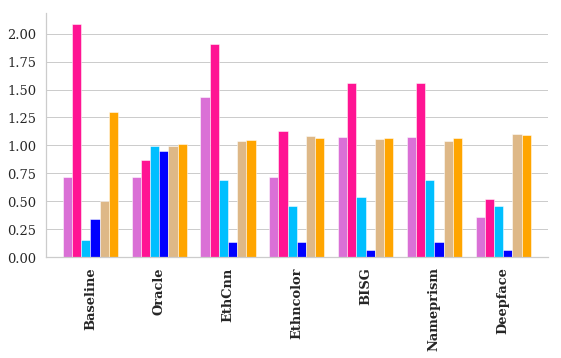

In [435]:
#fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(10,4))
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# # rc('text', usetex=True)

df = pd.DataFrame(skewloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (9,4.5)
plt.rcParams["font.family"] = 'DejaVu Serif'






#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)


#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")
plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')
for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)






# plt.ylabel("Population Skew")
plt.savefig('income_skew.pdf', bbox_inches = 'tight')

print(dft.to_latex())

\begin{table*}[t]
\centering
\begin{tabular}{lrrrrrrl}
\toprule
{} &  White\_Male &  White\_Female &  Asian\_Male &  Black\_Female &  Asian\_Female &  Black\_Male &          X \\
\midrule
Baseline  &   13.966731 &     13.806123 &   13.610320 &     13.371849 &     13.701660 &   12.389329 &   Baseline \\
Oracle    &   13.842765 &     13.761563 &   13.779062 &     13.607797 &     13.837519 &   13.776005 &     Oracle \\
EthCnn    &   13.852098 &     13.761563 &   13.743580 &     13.607797 &     13.873728 &   13.794003 &     EthCnn \\
Ethncolor &   13.852098 &     13.761563 &   13.779062 &     13.607797 &     13.928368 &   13.794003 &  Ethncolor \\
BISG      &   13.852098 &     13.761563 &   13.743580 &     13.607797 &     13.884835 &   13.854238 &       BISG \\
Nameprism &   13.842765 &     13.761563 &   13.743580 &     13.607797 &     13.826270 &   13.776005 &  Nameprism \\
Deepface  &   13.852098 &     13.761563 &   13.779062 &     13.674498 &     13.928368 &   13.854238 &   Deepface \\


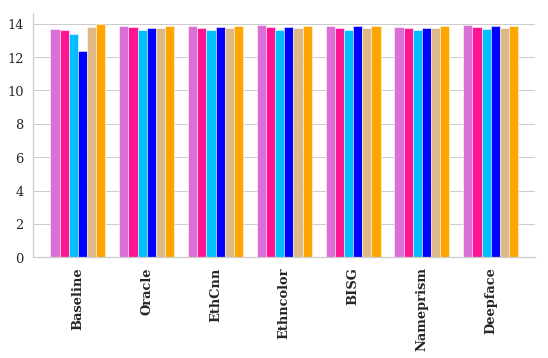

In [436]:
df = pd.DataFrame(attdloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns
plt.rcParams["figure.figsize"] = (9,4.5)


dft['X'] = dft.index

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.grid(False)




# plt.xlabel("Inference Algorithm")
# plt.ylabel("Median Attention")
plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')

for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)


plt.savefig('income_attention.pdf', bbox_inches = 'tight')

print('\\begin{table*}[t]')
print('\centering')
print(dft.to_latex())
print('\end{table*}')

\begin{table}[!htbp]
\centering
\begin{tabular}{lrrrrrrl}
\toprule
{} &  White\_Male &  White\_Female &  Asian\_Male &  Black\_Female &  Asian\_Female &  Black\_Male &          X \\
\midrule
Baseline  &   12.062709 &     11.893971 &   11.681461 &     11.420768 &     11.783738 &   10.278717 &   Baseline \\
Oracle    &   12.082218 &     11.344903 &   12.009464 &      9.919790 &     11.901356 &   11.107120 &     Oracle \\
EthCnn    &   12.064425 &     11.344903 &   11.822208 &     10.114049 &     10.909363 &   11.847767 &     EthCnn \\
Ethncolor &   12.017086 &     11.214381 &   12.705141 &      5.886369 &     12.546345 &   11.497894 &  Ethncolor \\
BISG      &   12.050338 &     11.257365 &   11.841404 &     10.792564 &     11.435587 &   12.226361 &       BISG \\
Nameprism &   12.074377 &     11.390479 &   11.883659 &      1.575067 &     11.834706 &    8.816815 &  Nameprism \\
Deepface  &   11.969683 &     11.024684 &   12.724860 &     11.077215 &     12.471594 &   12.216221 &   Deepface 

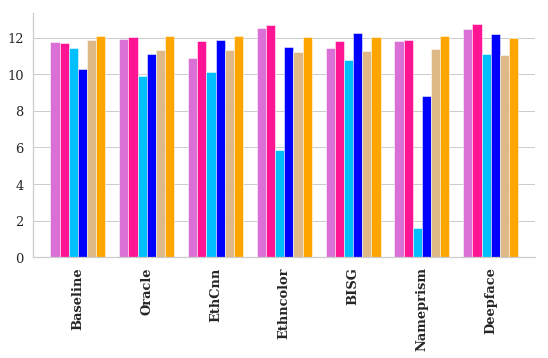

In [437]:
df = pd.DataFrame(DIloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns
plt.rcParams["figure.figsize"] = (9,4.5)


dft['X'] = dft.index

ax = dft.plot(x="X", y=sorted(list(dftcol)), width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.grid(False)



plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')

for spine in ('top', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)
#plt.xlabel("Inference Algorithm")
#plt.ylabel("Median Disparate Impact")

plt.savefig('income_DI.pdf', bbox_inches = 'tight')

print('\\begin{table}[!htbp]')
print('\centering')
print(dft.to_latex())
print('\end{table*}')

\begin{table}[!htbp]
\centering
\begin{tabular}{lrrrrrrl}
\toprule
{} &  White\_Male &  White\_Female &  Asian\_Male &  Black\_Female &  Asian\_Female &  Black\_Male &          X \\
\midrule
Baseline  &   16.171292 &     16.025686 &   15.857933 &     15.662074 &     15.931839 &   14.933330 &   Baseline \\
Oracle    &   15.859848 &     16.693149 &   15.809411 &     18.666942 &     16.089813 &   17.086537 &     Oracle \\
EthCnn    &   15.904667 &     16.693149 &   15.977218 &     18.308407 &     17.773147 &   16.061404 &     EthCnn \\
Ethncolor &   15.961107 &     16.887299 &   14.943759 &     31.457832 &     15.478641 &   16.549329 &  Ethncolor \\
BISG      &   15.923265 &     16.822950 &   15.951337 &     17.157383 &     16.900377 &   15.752530 &       BISG \\
Nameprism &   15.870154 &     16.626253 &   15.894600 &    117.564953 &     16.163056 &   21.533691 &  Nameprism \\
Deepface  &   16.030558 &     17.177872 &   14.920637 &     16.880767 &     15.565920 &   15.746976 &   Deepface 

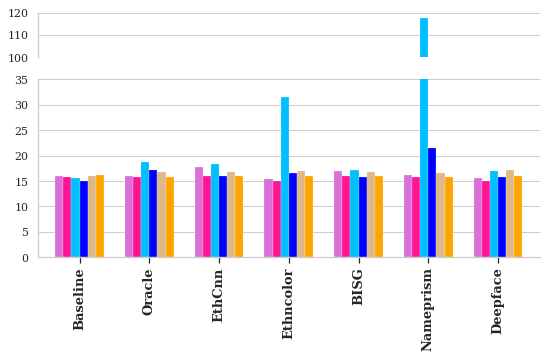

In [438]:
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

from matplotlib.ticker import ScalarFormatter


    
df = pd.DataFrame(DTloop_inc).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index
plt.rcParams["figure.figsize"] = (9,4.5)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4]})


dft.plot(x="X",y=sorted(list(dftcol)),logy = False, width = 0.7, 
              edgecolor='white',linewidth=0.2,kind="bar",color=map(d2c.get,sorted(list(dftcol))), ax = ax1)
dft.plot(x="X",y=sorted(list(dftcol)),logy = False, width = 0.7, 
              edgecolor='white',linewidth=0.2,kind="bar",color=map(d2c.get,sorted(list(dftcol))), ax = ax2)

for ax in [ax1,ax2]:
    ax.set_facecolor('white')
    ax.get_legend().remove()
    ax.tick_params(axis='x', which='both',labelsize=13)
    ax.tick_params(axis='y', which='both',labelsize=11)
    # ax.xaxis.set_minor_locator(AutoMinorLocator())
    # ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(ScalarFormatter())

    ax.yaxis.grid(True,which='both')
    ax.xaxis.grid(False)

ax1.set_ylim(100, 120)  # outliers only
ax2.set_ylim(0, 35)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# plt.legend(loc=(1.04,0),ncol=len(dft.columns))
# plt.xlabel("Inference Algorithm")
plt.xlabel(None)
plt.xticks(rotation=90,weight='bold')


# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
# ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# # ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# d = .015  # how big to make the diagonal lines in axes coordinates

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# # ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal



for spine in ('top', 'right'): # 'bottom', 'left'): 
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
    
#plt.ylabel("Median Disparate Treatment")
# plt.gca().set_axis_off()
# ax.axis('off')
# plt.show()
# plt.minorticks_on()

plt.savefig('income_DT.eps', bbox_inches = 'tight')


print('\\begin{table}[!htbp]')
print('\centering')
print(dft.to_latex())
print('\end{table}')

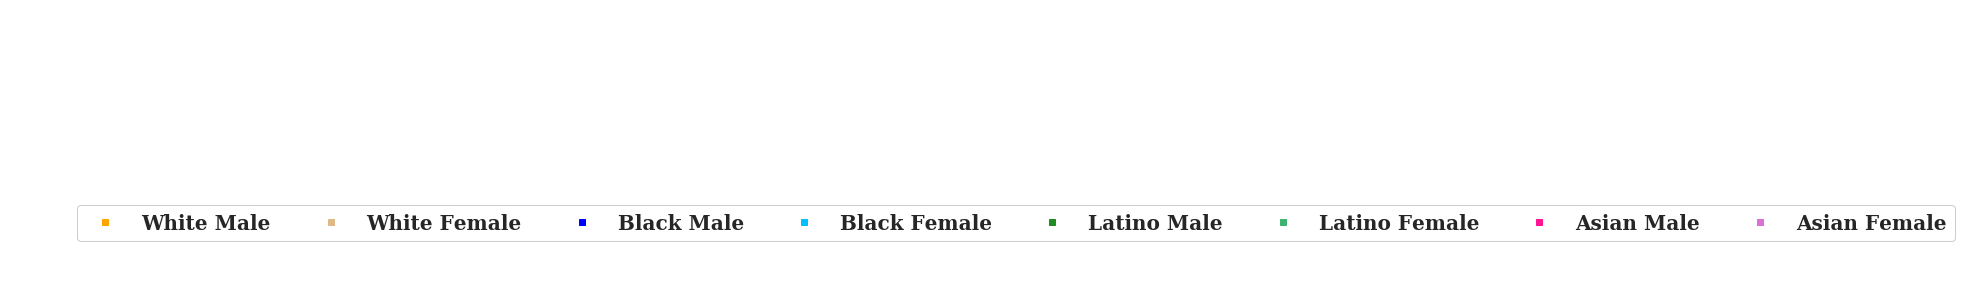

In [431]:
colors = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
cats = ['White Male', 'White Female', 'Black Male', 'Black Female', 'Latino Male', 'Latino Female', 'Asian Male', 'Asian Female']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(colors))]
labels = cats
legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                    frameon=True,ncol=len(colors),facecolor='white', prop = {'weight':'bold', 'size': 20})
plt.gca().set_axis_off()
plt.gca().set_facecolor('white')


def export_legend(legend, filename="legend.pdf", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [187]:
# df = pd.DataFrame(geoattdloop).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index

# ax = dft.plot(x="X", y=sorted(list(dftcol)),logy = True, width = 0.7, edgecolor='white',linewidth=0.2,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
# ax.set_facecolor('white')
# ax.get_legend().remove()

# plt.xlabel("None")

# dft

# # plt.xlabel("Inference Algorithm")
# # plt.ylabel("Median Geometric Attention")

# Compas Data

In [432]:
compas = pd.read_csv('compas_baseline_score.csv')
# compasbaseline['race+gender'] = compasbaseline['race'].astype(str)+'_'+compasbaseline['sex'].astype(str)

compasrank_og = []
for i, row in compas.iterrows():
    if row['race']=='Other':
        continue
    if row['race']=='African-American':
        row['race'] = 'Black'
    if row['race']=='Caucasian':
        row['race'] = 'White'
    if row['race']=='Hispanic':
        row['race'] = 'Latino'
    if row['race']=='Native American':
        continue
    print(i, end='\r')
    compasrank_og.append({'attr': str(row['race'])+'_'+str(row['sex']),'real_attr':str(row['race'])+'_'+str(row['sex']),'score':row['two_year_recid_pred']})

In [433]:
compasrank_og.sort(key=lambda x:x['score'],reverse=True)

In [434]:
n_sim = 100
L = len(compasrank_og)
K = 300
compasdist = getdist(compasrank_og)

NDKL_dic = {}

attd_d = {}
geoattd_d = {}
DI_d = {}
DT_d = {}
skew_d = {}

for s in range(n_sim):
    print(s)
    compasrank_shuffled_ethncolor = misinterpret(copy.deepcopy(compasrank_og), ethncolorpred)
    compasrank_shuffled_cnn = misinterpret(copy.deepcopy(compasrank_og), cnnpred)
    compasrank_shuffled_bisg = misinterpret(copy.deepcopy(compasrank_og), bisgpred)
    compasrank_shuffled_nameprism = misinterpret(copy.deepcopy(compasrank_og), nameprismpred)
    compasrank_shuffled_deepface = misinterpret(copy.deepcopy(compasrank_og), deepfacepred)
    
    compasdetconsort_og = det_const_sort(compasrank_og,compasdist,K)
    #compasdetconsort_shuff_dict = det_const_sort(compasrank_shuffled_dict,compasdist,K)
    compasdetconsort_shuff_ethncolor = det_const_sort(compasrank_shuffled_ethncolor,compasdist,K)
    compasdetconsort_shuff_cnn = det_const_sort(compasrank_shuffled_cnn,compasdist,K)
    compasdetconsort_shuff_bisg = det_const_sort(compasrank_shuffled_bisg,compasdist,K)
    compasdetconsort_shuff_nameprism = det_const_sort(compasrank_shuffled_nameprism,compasdist,K)
    compasdetconsort_shuff_deepface = det_const_sort(compasrank_shuffled_deepface,compasdist,K)
    
    method_names = ['Baseline','Oracle','EthCnn','Ethncolor','BISG','Nameprism','Deepface']

    rankedlists = [compasrank_og, compasdetconsort_og,compasdetconsort_shuff_cnn, compasdetconsort_shuff_ethncolor,compasdetconsort_shuff_bisg, compasdetconsort_shuff_nameprism, compasdetconsort_shuff_deepface]

    for method_name, rankedlist in zip(method_names, rankedlists):
        if method_name not in NDKL_dic:
            NDKL_dic[method_name] = []
        NDKL_dic[method_name].append(NDKL(rankedlist[:K], compasdist))
        
#     maind = None

    dist = compasdist

    for method_name, rankedlist in zip(method_names, rankedlists):
#         attd = None
#         if method_name == 'PerfectInference':
#             ndkl,maind,DI,DT,skewd,geoattd = showmetrics(compasdetconsort_og[:K],dist)
#             attd = maind
#         else:
        print(method_name)
        ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
        if method_name not in attd_d:
            attd_d[method_name] = {}
        if method_name not in geoattd_d:
            geoattd_d[method_name] = {}
        if method_name not in DI_d:
            DI_d[method_name] = {}
        if method_name not in DT_d:
            DT_d[method_name] = {}
        if method_name not in skew_d:
            skew_d[method_name] = {}
        
        for cat in attd:
            if cat not in attd_d[method_name]:
                attd_d[method_name][cat] = []
            attd_d[method_name][cat].append(attd[cat])
            
        for cat in geoattd:
            if cat not in geoattd_d[method_name]:
                geoattd_d[method_name][cat] = []
            geoattd_d[method_name][cat].append(geoattd[cat])
            
        for cat in DI:
            if cat not in DI_d[method_name]:
                DI_d[method_name][cat] = []
            DI_d[method_name][cat].append(DI[cat])
            
        for cat in DT:
            if cat not in DT_d[method_name]:
                DT_d[method_name][cat] = []
            DT_d[method_name][cat].append(DT[cat])
            
        for cat in skewd:
            if cat not in skew_d[method_name]:
                skew_d[method_name][cat] = []
            skew_d[method_name][cat].append(skewd[cat])

0
Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.83045067639

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

Baseline
NDKL of this ranking:  0.32578705888467985
Skew Measure:  {'Black_Female': 0.35325518414330054, 'Latino_Male': 0.45418386157289625, 'Latino_Female': 0.23655823216510485, 'Black_Male': 1.7945831596021242, 'White_Female': 0.20118529910912128, 'White_Male': 0.37088031681162875}
	 Mean skew : 0.5684410089006959
	 Standard deviation of skew : 0.5548028733321535
	 Skew bias ratio:  0.11210698040525797
Groupwise Exposure:  {'Black_Male': 13.889520968509133, 'White_Male': 13.511907721365986, 'Latino_Male': 13.558269028500204, 'White_Female': 16.794877895704197, 'Black_Female': 13.167827837274146, 'Latino_Female': 13.158045635063056}
	 Mean exposure : 14.013408181069453
	 Standard deviation of exposure : 1.2686756465618012
	 Exposure bias ratio:  0.7834558677219456
Disparate Treatment Metric
Group exposure/utility:  {'Black_Male': 15.326996593679768, 'White_Male': 15.070913365015306, 'Latino_Male': 15.094460849933437, 'White_Female': 17.866154208442335, 'Black_Female': 14.8304506763936

In [182]:
attdloop_comp = []
geoattdloop_comp = []
ndklloop_comp = []
DIloop_comp = []
DTloop_comp = []
skewloop_comp = []


for method_name in method_names:
    attd = {}
    for cat in attd_d[method_name]:
        attd[cat]= np.median(attd_d[method_name][cat])
    attdloop_comp.append(attd)
    
    geoattd = {}
    for cat in geoattd_d[method_name]:
        geoattd[cat]= np.mean(geoattd_d[method_name][cat])
    geoattdloop_comp.append(geoattd)
    
    DI = {}
    for cat in DI_d[method_name]:
        DI[cat]= np.median(DI_d[method_name][cat])
    DIloop_comp.append(DI)
    
    DT = {}
    for cat in DT_d[method_name]:
        DT[cat]= np.median(DT_d[method_name][cat])
    DTloop_comp.append(DT)
    
    skewd = {}
    for cat in skew_d[method_name]:
        skewd[cat]= np.median(skew_d[method_name][cat])
    skewloop_comp.append(skewd)

In [71]:


# #This is a simple last name frequency based classifier, not very accurate. Will also add charts for nameprism 
# #when we get access to it
# import copy 

# #compasbaseline_rank_shuffled_dict = misinterpret(copy.deepcopy(compasbaseline_original_rank), dictpred)
# compasbaseline_rank_shuffled_cnn = misinterpret(copy.deepcopy(compasbaseline_original_rank), cnnpred)
# compasbaseline_rank_shuffled_ethncolor = misinterpret(copy.deepcopy(compasbaseline_original_rank), ethncolorpred)
# compasbaseline_rank_shuffled_bisg = misinterpret(copy.deepcopy(compasbaseline_original_rank), bisgpred)
# compasbaseline_rank_shuffled_nameprism = misinterpret(copy.deepcopy(compasbaseline_original_rank), nameprismpred)
# compasbaseline_rank_shuffled_deepface = misinterpret(copy.deepcopy(compasbaseline_original_rank), deepfacepred)

In [72]:
# compasdist = getdist(compasbaseline_original_rank)

In [73]:
# set([i['attr'] for i in compasbaseline_original_rank])

In [74]:
# L = len(compasbaseline_original_rank)
# K = 250

In [75]:
# compasdetconsort_og = det_const_sort(compasbaseline_original_rank,compasdist,K)
# #compasdetconsort_shuff_dict = det_const_sort(compasbaseline_rank_shuffled_dict,compasdist,K)
# compasdetconsort_shuff_ethncolor = det_const_sort(compasbaseline_rank_shuffled_ethncolor,compasdist,K)
# compasdetconsort_shuff_cnn = det_const_sort(compasbaseline_rank_shuffled_cnn,compasdist,K)
# compasdetconsort_shuff_bisg = det_const_sort(compasbaseline_rank_shuffled_bisg,compasdist,K)
# compasdetconsort_shuff_nameprism = det_const_sort(compasbaseline_rank_shuffled_nameprism,compasdist,K)
# compasdetconsort_shuff_deepface = det_const_sort(compasbaseline_rank_shuffled_deepface,compasdist,K)

In [161]:
# method_names = ['vanilla - unfair','perfectinference','cnn','ethncolor','bisg','nameprism','deepface']

# rankedlists = [compasbaseline_original_rank, compasdetconsort_og,compasdetconsort_shuff_cnn, compasdetconsort_shuff_ethncolor, compasdetconsort_shuff_bisg, compasdetconsort_shuff_nameprism, compasdetconsort_shuff_deepface]

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print(method_name, NDKL(rankedlist[:K], compasdist))

### Logarithmic attention

In [162]:
# maind = None

# attdloop = []
# ndklloop = []
# DIloop = []
# DTloop = []
# skewloop = []
# geoattdloop = []

# dist = compasdist

# for method_name, rankedlist in zip(method_names, rankedlists):
#     print('\n\n',method_name.title())
#     attd = None
#     if method_name == 'perfectinference':
#         ndkl,maind,DI,DT,skewd,geoattd = showmetrics(compasdetconsort_og[:K],dist)
#         attd = maind
#     else:
#         ndkl,attd,DI,DT,skewd,geoattd = showmetrics(rankedlist[:K],dist)
#     attdloop.append(attd)
#     ndklloop.append(ndkl)
#     DIloop.append(DI)
#     DTloop.append(DT)
#     skewloop.append(skewd)
#     geoattdloop.append(geoattd)

#     if method_name not in ['vanilla - unfair','perfectinference']:
#         getheatmap(maind,attd,'Perfect Inference',method_name.title())

\begin{table}[!htbp]
\centering
\begin{tabular}{lrrrrrrrl}
\toprule
{} &  Black\_Female &  Latino\_Male &  Latino\_Female &  Black\_Male &  White\_Female &  White\_Male &  Asian\_Male &                 X \\
\midrule
Vanilla/Unfair   &      0.353255 &     0.454184 &       0.236558 &    1.794583 &      0.201185 &    0.370880 &         NaN &    Vanilla/Unfair \\
PerfectInference &      0.989095 &     0.999188 &       0.946020 &    1.011762 &      0.965644 &    1.004960 &    0.668802 &  PerfectInference \\
EthCnn           &      1.483638 &     0.908354 &       0.709533 &    1.528719 &      0.462710 &    0.179460 &    0.000201 &            EthCnn \\
Ethncolor        &      1.218704 &     0.499601 &       0.591289 &    1.240700 &      0.885174 &    0.741757 &    0.000201 &         Ethncolor \\
BISG             &      1.448313 &     0.908354 &       0.709533 &    1.521334 &      0.482828 &    0.203388 &    0.000201 &              BISG \\
Nameprism        &      1.448313 &     1.044605 &     

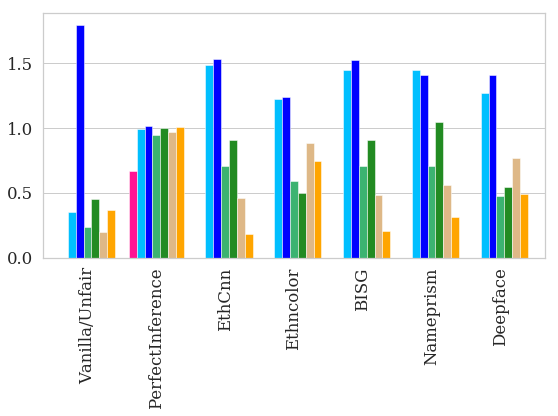

In [235]:
df = pd.DataFrame(skewloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (9,4.5)
plt.rcParams["font.family"] = 'DejaVu Serif'



#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")
plt.xlabel(None)




# plt.ylabel("Population Skew")
plt.savefig('compas_skew.svg', bbox_inches = 'tight')

print('\\begin{table}[!htbp]')
print('\centering')
print(dft.to_latex())
print('\end{table}')

\begin{table}[!htbp]
\centering
\begin{tabular}{lrrrrrrrl}
\toprule
{} &  Black\_Male &  White\_Male &  Latino\_Male &  White\_Female &  Black\_Female &  Latino\_Female &  Asian\_Male &                 X \\
\midrule
Vanilla/Unfair   &   13.889521 &   13.511908 &    13.558269 &     16.794878 &     13.167828 &      13.158046 &         NaN &    Vanilla/Unfair \\
PerfectInference &   13.852011 &   13.752570 &    13.702422 &     13.782009 &     13.800042 &      13.426691 &   13.045743 &  PerfectInference \\
EthCnn           &   13.852011 &   13.852796 &    13.696384 &     13.782009 &     13.728029 &      13.426691 &   13.057879 &            EthCnn \\
Ethncolor        &   14.088412 &   13.607797 &    13.570338 &     13.575295 &     13.728029 &      13.569186 &   13.158046 &         Ethncolor \\
BISG             &   13.852011 &   13.852796 &    13.696384 &     13.782009 &     13.728029 &      13.451663 &   13.045743 &              BISG \\
Nameprism        &   14.790768 &   13.132566 &    13.0

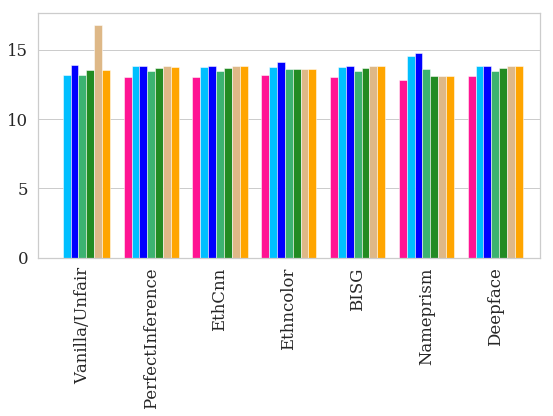

In [236]:
df = pd.DataFrame(attdloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (9,4.5)




#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")
plt.xlabel(None)




# plt.ylabel("Population Skew")
plt.savefig('compas_attention.svg', bbox_inches = 'tight')

print('\\begin{table}[H]')
print('\centering')
print(dft.to_latex())
print('\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrrl}
\toprule
{} &  Black\_Male &  White\_Male &  Latino\_Male &  White\_Female &  Black\_Female &  Latino\_Female &  Asian\_Male &                 X \\
\midrule
Vanilla/Unfair   &   12.586862 &   12.114173 &    12.179621 &     15.787837 &     11.692117 &      11.689578 &         NaN &    Vanilla/Unfair \\
PerfectInference &   12.922174 &   11.258325 &    11.457005 &      9.905381 &     11.176072 &       8.779108 &    9.667039 &  PerfectInference \\
EthCnn           &   12.094067 &   12.993221 &    10.964757 &     11.581299 &      9.562472 &       7.849300 &   10.171605 &            EthCnn \\
Ethncolor        &    6.431265 &   12.782053 &    11.621058 &     11.375844 &      4.674550 &      10.019250 &   12.938732 &         Ethncolor \\
BISG             &   12.394313 &   12.942311 &    11.334336 &     11.570230 &     10.308773 &       8.779887 &    9.667039 &              BISG \\
Nameprism        &    7.430136 &   12.318784 &    10.04031

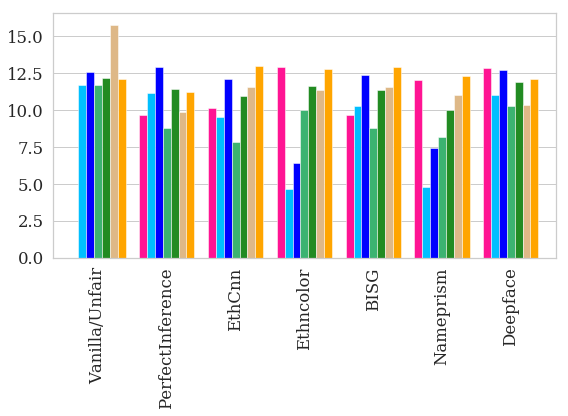

In [237]:
df = pd.DataFrame(DIloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (9,4.5)




#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")
plt.xlabel(None)




# plt.ylabel("Population Skew")
plt.savefig('compas_DI.svg', bbox_inches = 'tight')

print('\\begin{table}[H]')
print('\centering')
print(dft.to_latex())
print('\end{table}')

\begin{table}[H]
\centering
\begin{tabular}{lrrrrrrrl}
\toprule
{} &  Black\_Male &  White\_Male &  Latino\_Male &  White\_Female &  Black\_Female &  Latino\_Female &  Asian\_Male &                 X \\
\midrule
Vanilla/Unfair   &   15.326997 &   15.070913 &    15.094461 &     17.866154 &     14.830451 &      14.810986 &         NaN &    Vanilla/Unfair \\
PerfectInference &   14.848755 &   16.799448 &    16.387988 &     19.177335 &     17.040996 &      20.715449 &   17.605329 &  PerfectInference \\
EthCnn           &   15.871581 &   14.785622 &    17.112324 &     16.355915 &     19.709319 &      23.210198 &   16.763158 &            EthCnn \\
Ethncolor        &   31.114978 &   14.442054 &    15.815043 &     16.154956 &     40.421699 &      18.379479 &   13.386017 &         Ethncolor \\
BISG             &   15.479663 &   14.843693 &    16.571236 &     16.462660 &     18.281417 &      20.837549 &   17.605329 &              BISG \\
Nameprism        &   29.501970 &   14.000452 &    17.13704

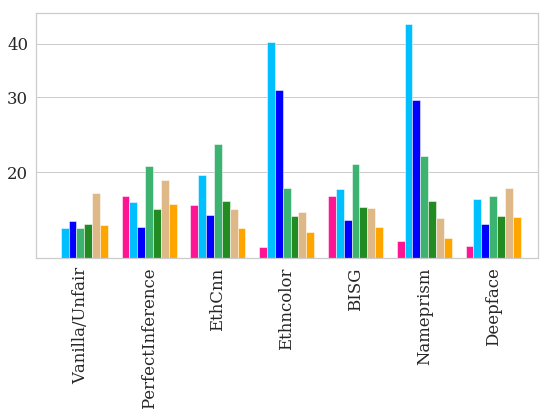

In [238]:
df = pd.DataFrame(DTloop_comp).T
df.columns = method_names

dft = df.T
dftcol = dft.columns

dft['X'] = dft.index

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (9,4.5)




#plt.grid(True)

ax = dft.plot(x="X", y=sorted(list(dftcol)),logy=True,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(False)
ax.yaxis.grid(True,which='both')
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.legend(loc=(1.04,0))
# plt.xlabel("Inference Algorithm")
plt.xlabel(None)




# plt.ylabel("Population Skew")
plt.savefig('compas_DT.svg', bbox_inches = 'tight')

print('\\begin{table}[H]')
print('\centering')
print(dft.to_latex())
print('\end{table}')

In [186]:
# df = pd.DataFrame(geoattdloop_comp).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index

# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.alpha'] = 1
# plt.rcParams['grid.color'] = "#cccccc"
# plt.rcParams['axes.edgecolor'] = "#cccccc"



# #plt.grid(True)

# ax = dft.plot(x="X", y=sorted(list(dftcol)),width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
# ax.set_facecolor('white')
# ax.get_legend().remove()
# ax.xaxis.grid(False)
# ax.yaxis.grid(True,which='both')

# #plt.legend(loc=(1.04,0))
# # plt.xlabel("Inference Algorithm")
# plt.xlabel(None)




# # plt.ylabel("Population Skew")
# plt.savefig('compas_geoattd.svg', bbox_inches = 'tight')

In [181]:
# attdloop_comp

In [82]:
# for method_name, rankedlist in zip(method_names, rankedlists):
#     attd = get_attention(rankedlist[:K],dist="geometric", p=0.1)
#     vals = attd.values()
#     print(method_name, attd)
#     print("Exposure bias ratio: ", min(vals)/max(vals))

In [83]:
# df = pd.DataFrame(geoattdloop).T
# df.columns = method_names

# dft = df.T
# dftcol = dft.columns

# dft['X'] = dft.index

# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.alpha'] = 1
# plt.rcParams['grid.color'] = "#cccccc"
# plt.rcParams['axes.edgecolor'] = "#cccccc"



# #plt.grid(True)

# ax = dft.plot(x="X", y=sorted(list(dftcol)),logy=True,width = 0.8, edgecolor='white',linewidth=0.5,kind="bar",color=map(d2c.get,sorted(list(dftcol))))
# ax.set_facecolor('white')
# ax.get_legend().remove()
# ax.xaxis.grid(False)
# ax.yaxis.grid(True,which='both')

# #plt.legend(loc=(1.04,0))
# # plt.xlabel("Inference Algorithm")
# plt.xlabel(None)




# # plt.ylabel("Population Skew")
# plt.savefig('compas_geoattd.svg', bbox_inches = 'tight')

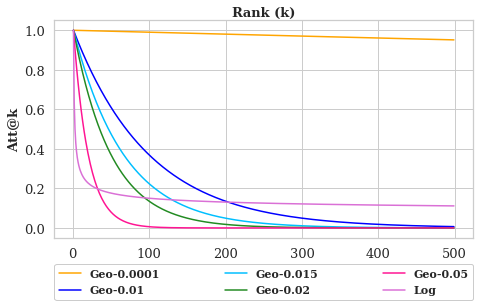

In [96]:
from matplotlib.ticker import ScalarFormatter
geo_df = {}
geo_df['rank']=[]
geo_df['value']=[]
geo_df['type'] = []

prob_vals = [0.0001 ,0.01,0.015, 0.02, 0.05, 'log']

for p in prob_vals:
    for i in range(1,500):
        if p!='log':
            init_val = 1/p
            geo_att_i = init_val*((1-p)**(i-1))*p    
            geo_df['rank'].append(i)
            geo_df['value'].append(geo_att_i)
            geo_df['type'].append('geo-'+str(p))
        else:
            log_att_i = 1/(math.log2(1+i))
            geo_df['rank'].append(i)
            geo_df['value'].append(log_att_i)
            geo_df['type'].append('log')

geo_df = pd.DataFrame(geo_df)
# 'mediumseagreen'
color_list = ['orange', 'blue', 'deepskyblue', 'forestgreen', 'deeppink','orchid']

sns.lineplot(data= geo_df, x= 'rank', y='value', hue='type', palette=color_list)
        

plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (7.5,4)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

# ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[0],marker='o')
ax = plt.gca()
ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')
ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()


ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

# for spine in ('top', 'right'): # 'bottom', 'left'): 
#     plt.gca().spines[spine].set_visible(False)


plt.ylabel('Att@k',fontsize=13,weight='bold')
plt.xlabel('Rank (k)', fontsize =13,weight='bold')


legend_list = ['Geo-'+str(i) if i!='log' else 'Log'  for i in prob_vals]
plt.legend(legend_list,
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.285,1,0.2), loc="lower left",mode="expand", borderaxespad=0, ncol=3,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('geometric_log_ratio.pdf', bbox_inches='tight')

# X= [i for i in range(1,500)]
# ylog = logarithmic_attn_scores
# ygeo = geometric_attn_scores

# # plt.plot(X,ylog, label ='log')
# plt.plot(X,ygeo, label='geo')
# plt.legend()
# plt.show()
    

In [103]:
geo_df = pd.DataFrame(geo_df)
display(geo_df[geo_df['rank']==300])

,rank,value,type
299,300,9.705411e-01,geo-0.0001
798,300,4.953626e-02,geo-0.01
1297,300,1.090016e-02,geo-0.015
1796,300,2.380108e-03,geo-0.02
2295,300,2.184530e-07,geo-0.05
2794,300,1.214533e-01,log
